# Neural Network from scratch
---

### Imports

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Architecture
Our neural network will have one hidden layer containing 4 nodes, 2 input nodes, and 1 output node.

In [2]:
NEURAL_NET = [
    {"prev_layer_neurons": 2, "current_layer_neurons": 4, "activation": "relu"},
    {"prev_layer_neurons": 4, "current_layer_neurons": 1, "activation": "sigmoid"}
]

### Function to initiate of weights and bias values for each layer randomnly

In [3]:
def initialize_neural_network():
    np.random.seed(150)
    weights_biases_map = {}
    
    cnt = 1
    
    # for every layer in the neural network
    for layer in NEURAL_NET:
        
        # calculating input and output neurons
        input_neurons = layer["prev_layer_neurons"]
        output_neurons = layer["current_layer_neurons"]
        
        # initializing weights and biases matrices
        weights_biases_map['W' + str(cnt)] = 0.1 * np.random.randn(output_neurons, input_neurons)
        weights_biases_map['b' + str(cnt)] = 0.1 * np.random.randn(output_neurons, 1)
        
        cnt += 1
        
    return weights_biases_map

### Custom Activation functions

In [4]:
# Forward propagation sigmoid activation function
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

# Backward propagation sigmoid activation function
def sigmoid_deriviative(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

# Forward propagation ReLu activation function
def relu(Z):
    return np.maximum(0,Z)

# Background propagation ReLu activation function
def relu_deriviative(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

### Function for Forward propagation

In [5]:
def forward_propagation(current_weights, weights_biases_map):
    
    cache = {}
    current_activation = current_weights
    
    cnt = 1
    
    # For every layer in the neural network
    for layer in NEURAL_NET:
        
        # Activation from previous layer
        before_activation = current_activation
        
        # Weights and biases for current layer
        W = weights_biases_map['W' + str(cnt)]
        b = weights_biases_map['b' + str(cnt)]
        
        # Finding Z = WX + b
        current_Z = np.dot(W, before_activation) + b
        
        # Finding the current layer's activation function
        if layer["activation"] == "relu":
            act_func = relu
        elif layer["activation"] == "sigmoid":
            act_func = sigmoid
        else:
            raise Exception('Non-supported activation function')
        
        # Applying the activation function
        current_activation = act_func(current_Z)
        
        # Caching the calculated matrices
        cache["A" + str(cnt - 1)] = before_activation
        cache["Z" + str(cnt)] = current_Z
        
        cnt += 1
        
    return (current_activation, cache)


### Full backward propagation

In [6]:
def full_backward_propagation(predicted_Y, actual_Y, cache, params_values):
    
    # map the store the gradients
    gradients = {}
    actual_Y = actual_Y.reshape(predicted_Y.shape)
    before_activation_diff = np.divide(1 - actual_Y, 1 - predicted_Y)- np.divide(actual_Y, predicted_Y) 
    
    # reversing the neural network for backpropagation
    neural_net_reversed = reversed(list(enumerate(NEURAL_NET)))
    
    for index, layer in neural_net_reversed:
        
        curr_pos = index + 1
        
        # stroing activation function for the current layer
        current_activation_diff = before_activation_diff
        
        before_activation = cache["A" + str(index)]
        current_Z = cache["Z" + str(curr_pos)]
        
        # weights and biases for current layer
        W = params_values["W" + str(curr_pos)]
        b = params_values["b" + str(curr_pos)]
        
        # Finding the current layer's activation function
        if layer['activation'] == "relu":
            act_func = relu_deriviative
        elif layer['activation'] == "sigmoid":
            act_func = sigmoid_deriviative
        
        # Finding the derivative of the Z matrix (Z = WX + b)
        current_Z_derv = act_func(current_activation_diff, current_Z)
        
        # Finding the derivative of the W matrix 
        current_W_derv = np.dot(current_Z_derv, before_activation.T) / before_activation.shape[1]
        
        # Finding the derivative of the b matrix
        current_b_derv = np.sum(current_Z_derv, axis=1, keepdims=True) / before_activation.shape[1]
        
        # Finding the derivative of the previous activation function
        before_activation_diff = np.dot(W.T, current_Z_derv)
        
        # Updating the gradients values
        gradients["dW" + str(curr_pos)] = current_W_derv
        gradients["db" + str(curr_pos)] = current_b_derv
    
    return gradients

### Function to calculate Cross-Entropy loss 

In [7]:
def cross_entropy_loss(predicted_Y, true_Y):
    shape = predicted_Y.shape[1]
    positive_label_loss = np.dot(true_Y, np.log(predicted_Y).T)
    negative_label_loss = np.dot(1 - true_Y, np.log(1 - predicted_Y).T)
    total_loss = (positive_label_loss + negative_label_loss) * (-1 / shape)
    return np.squeeze(total_loss)

### Function to calculate the accuracy

In [8]:
def calculate_accuracy(predicted_Y, true_Y):
    predicted_Y_ = np.copy(predicted_Y)
    predicted_Y_[predicted_Y_ <= 0.5] = 0
    predicted_Y_[predicted_Y_ > 0.5] = 1
    accuracy = (predicted_Y_ == true_Y).all(axis=0).mean()
    return accuracy

### Function to update weights and biases values after epoch

In [9]:
def update(weights_biases, gradients, learning_rate):

    for index in range (len(NEURAL_NET)):
        weights_biases["W" + str(index+1)] -= learning_rate * gradients["dW" + str(index+1)]        
        weights_biases["b" + str(index+1)] -= learning_rate * gradients["db" + str(index+1)]

    return weights_biases

### Function to train the model using the above functions

In [56]:
def train(X, Y, epochs, learning_rate):
    
    # 1. Randomnly initialize the weights and biases of the model
    weights_biases = initialize_neural_network()
    print('Initialized Weights and Biases:')
    print(weights_biases)
    
    # 2. Initialize lists to store the loss and accuracy history overtime the training of model
    overtime_loss = []
    overtime_accuracy = []
    
    # 3. For every epoch, do the following
    for epoch in range(epochs):
        
        # 4. Perform forward propagation through the neural network
        Y_hat, cashe = forward_propagation(X, weights_biases)
        
        # 5. Calculate the cross-entropy loss for every forward propagation in each epoch
        cost = cross_entropy_loss(Y_hat, Y)
        overtime_loss.append(cost)
        
        # 6. Calculate the accuracy for every forward propagation in each epoch
        accuracy = calculate_accuracy(Y_hat, Y)
        overtime_accuracy.append(accuracy)
        
        # 7. Perform the backward propagation through the neural network, to calculate the gradients
        gradients = full_backward_propagation(Y_hat, Y, cashe, weights_biases)
        
        # 8. Update the model's weights and biases (learnable parameters)
        weights_biases = update(weights_biases, gradients, learning_rate)
        print('The updated Weights and Biases values:')
        print(weights_biases)
        
        # 9. Display the performance of the model at the end of each epoch
        print("Iteration: {} - loss: {:.10f} - accuracy: {:.10f}".format(epoch, cost, accuracy))
            
    return weights_biases, overtime_loss, overtime_accuracy

## Testing model with generated dataset

### Create artificial dataset

In [57]:
X, y = make_moons(n_samples = 500, noise = 0.19, random_state = 21)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print("Shape of X: ", X.shape)
print("Shape of Y: ", y.shape)

Shape of X:  (500, 2)
Shape of Y:  (500,)


### Function to plot the dataset

In [58]:
def plot_dataset(X, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', edgecolors='black', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', edgecolors='black', label='Class 1')
    plt.title('Dataset')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

### Visualization of the data set

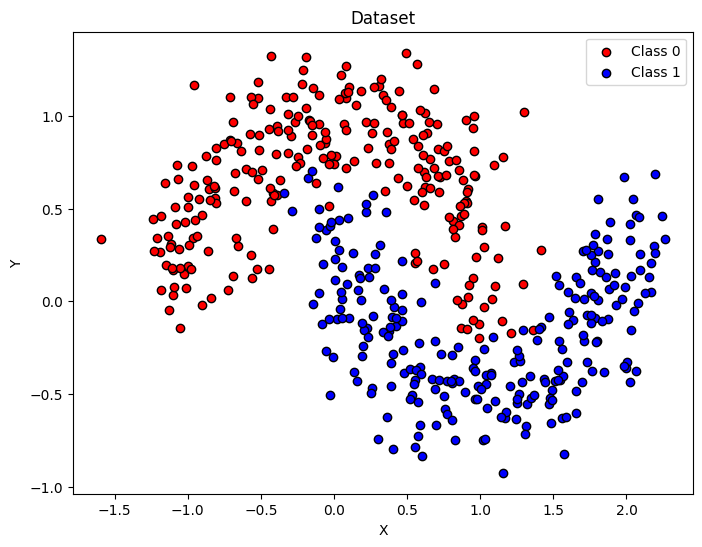

In [59]:
plot_dataset(X, y)

### Testing the model performance on our dataset

In [60]:
weights_biases, loss, accuracy = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), 200, 0.5)

Initialized Weights and Biases:
{'W1': array([[-0.02313832,  0.03906132],
       [ 0.03582975,  0.05662445],
       [ 0.0166234 ,  0.19134121],
       [ 0.03029027, -0.08308263]]), 'b1': array([[-0.00601423],
       [-0.00942941],
       [-0.13677448],
       [-0.05925181]]), 'W2': array([[-0.03724657,  0.17277671,  0.26928594, -0.13758694]]), 'b2': array([[0.19573157]])}
The updated Weights and Biases values:
{'W1': array([[-0.02401605,  0.0419243 ],
       [ 0.04777729,  0.04299543],
       [ 0.01404213,  0.17396533],
       [ 0.02198475, -0.08028476]]), 'b1': array([[-0.00230721],
       [-0.01368039],
       [-0.15511345],
       [-0.06561278]]), 'W2': array([[-0.04019573,  0.17101968,  0.2660948 , -0.13680829]]), 'b2': array([[0.17796341]])}
Iteration: 0 - loss: 0.6972940771 - accuracy: 0.5150000000
The updated Weights and Biases values:
{'W1': array([[-0.02478867,  0.04507948],
       [ 0.06033116,  0.0301916 ],
       [ 0.01242245,  0.16301369],
       [ 0.01804887, -0.07849716]

### Getting Predictions

In [61]:
# Prediction
Y_test_hat, _ = forward_propagation(np.transpose(X_test), weights_biases)

### Performance of our neural network

In [62]:
# Accuracy achieved on the test set
acc_test = calculate_accuracy(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {}".format(acc_test))

Test set accuracy: 0.88


### Function to plot loss history

In [63]:
def plot_loss(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-', color='r', linewidth=1)
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

### Function to plot accuracy history

In [64]:
def plot_accuracy(accuracy_history):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, linestyle='-', color='r', linewidth=1)
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

### Loss vs Epoch

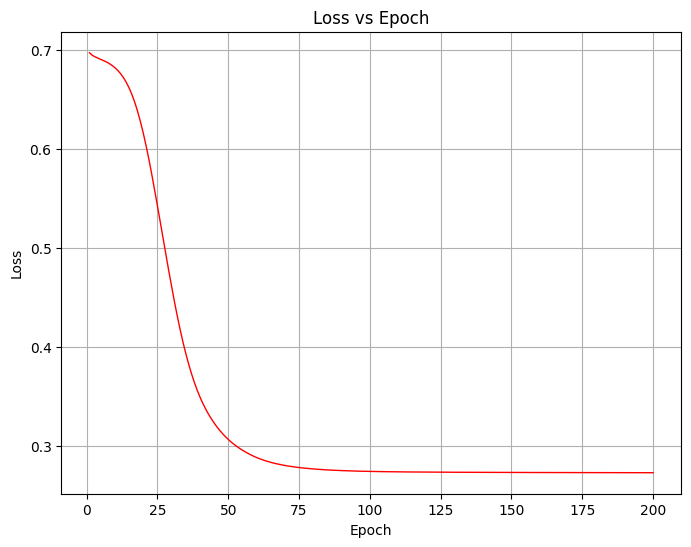

In [65]:
plot_loss(loss)

### Accuracy vs Epoch

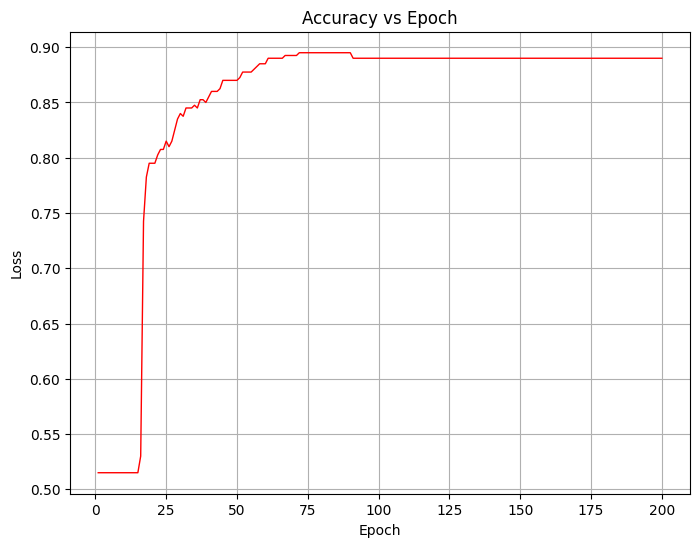

In [66]:
plot_accuracy(accuracy)

### Reason for the above observation

We see that the loss decreases as the number of epochs progresses, on the other hand and the accuracy of our model increases over time. This is a clear indication of the model being trained and improved on the data. The model updates its weights and biases in the neural network after each epoch so that it accurately predicts the any new data.